<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/08_Self_Supervised_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# 设置proxy
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

# MVP（以前的 TSBERT）：时间序列模型的自监督预训练🤗

> MVP (previously TSBERT): Self-Supervised Pretraining of Time Series Models 🤗

这是由 Ignacio Oguiza ( oguiza@timeseriesAI.co) 创建的非官方 PyTorch 实现，基于：
> This is an unofficial PyTorch implementation created by Ignacio Oguiza (oguiza@timeseriesAI.co) based on:

Zerveas，G.，Jayaraman，S.，Patel，D.，Bhamidipaty，A.和Eickhoff，C.（2020）。基于 Transformer 的多变量时间序列表示学习框架。arXiv预印本arXiv：2010.02803v2..据我所知，没有可用的官方实施（2020 年 10 月 10 日）
> * Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). A Transformer-based Framework for Multivariate Time Series Representation Learning. arXiv preprint arXiv:2010.02803v2.. No official implementation available as far as I know (Oct 10th, 2020)

MVP 是一种自监督训练方法，可用于在不使用任何标签的情况下预训练时间序列模型。该方法与 BERT 非常相似。
> `MVP` is a self-supervised training method that can be used to pretrain time series models without using any labels. The approach is very similar to BERT.

`MVP` is performed in 2 steps: 
1. 预训练选定的架构，无需任何标签。训练完成后，预训练的模型将自动保存到给定的 target_dir/fname 中。
   > Pretrain the selected architecture without any labels. When training is finished, the pretrained model will be automatically saved to the given target_dir/fname.
2. 使用 pretrained=True 指示weights_path (target_dir/fname) 来微调或训练相同的架构。
   > Fine-tune or train the same architecture with pretrained=True indicating the weights_path (target_dir/fname).

在此笔记本中，我们将使用 UCR 数据集 (LSST)，其中包含大约 2500 个训练样本和 2500 个验证样本。为了分析 MVP 的影响，我们将：
> In this notebook we'll use a UCR dataset (LSST) that contains around 2500 training and 2500 validation samples. To analyze the impact of `MVP` we'll:

1. 使用监督学习使用 10% 或 100% 的标签来设置基线。
2. > use supervised learning to set a baseline using 10% or 100% of the labels.
3. 使用 100% 不带标签的训练数据集来预训练模型。
4. > pretrain a model using 100% of the training dataset without labels.
5. 使用 10% 或 100% 的训练数据集（带标签）进行微调或训练。
6. > fine tune or train using 10% or 100% of the training dataset (with labels). 

MVP 和原始论文之间的一个关键区别是，您可以使用您选择的任何架构，只要它具有“head”属性并且可以采用 custom_head kwarg。 tsai 库中在 Plus 中完成的架构符合此标准。为了演示其工作原理，我们将在本笔记本中使用 InceptionTimePlus。
> A key difference between `MVP` and the original paper is that you can use any architecture of your choice as long as it has a "head" attribute and can take a custom_head kwarg. Architectures finished in Plus in the `tsai` library meet this criteria. To demonstrate how this works, we'll use InceptionTimePlus throughout this notebook.

### Results

<img src="https://github.com/timeseriesAI/tsai/blob/master/tutorial_nbs/images/TSBERT_data.jpg?raw=1">
<img src="https://github.com/timeseriesAI/tsai/blob/master/tutorial_nbs/images/TSBERT_chart.jpg?raw=1">

这些结果表明以下内容：

> These results indicate the following: 


* 与监督学习（从头开始训练）相比，预训练+微调/训练可以提高性能。
* > Pretraining + fine-tuning/ training improves performance when compared to supervised learning (training from scratch).
* 在这种情况下，微调和训练预训练模型之间没有太大区别。这可能取决于数据集。尝试这两种方法会很好。
* > In this case, there's not much difference between fine-tuning and training a pretrained model. This may be dataset dependent. It'd be good to try both approaches. 
* 可用的标签越少，预训练的效果似乎就越好。
* > The fewer labels available, the better pretraining seems to work. 

# Import libraries 📚

In [2]:
from tsai.all import *
from IPython.display import clear_output
my_setup()

os              : Linux-5.15.0-97-generic-x86_64-with-glibc2.17
python          : 3.8.18
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.2.1+cu121
device          : 1 gpu (['NVIDIA GeForce GTX 1060 6GB'])
cpu cores       : 6
threads per cpu : 2
RAM             : 31.22 GB
GPU memory      : [6.0] GB


# Prepare data 🏭

In [3]:
dsid = 'LSST'
X, y, splits = get_UCR_data(dsid, split_data=False)


我们现在将创建 2 个数据加载器，其中包含 100% 的训练样本和 100% 的验证样本。其中之一不包含 y（未标记）。另一张包含标签。我们将使用未标记的数据集 (udls) 来预训练模型。

> We'll now create 2 dataloaders with 100% of the training and 100% of validation samples.
> One of them doesn't contain the y (unlabeled). The other one contains the labels. 
> We'll use the unlabeled dataset (udls) to pretrain the model.

X      - shape: [4925 samples x 6 features x 36 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (4925,)  type: memmap  dtype:<U2  n_classes: 14 (351 samples per class) ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']  isnan: False
splits - n_splits: 2 shape: [2459, 2466]  overlap: False


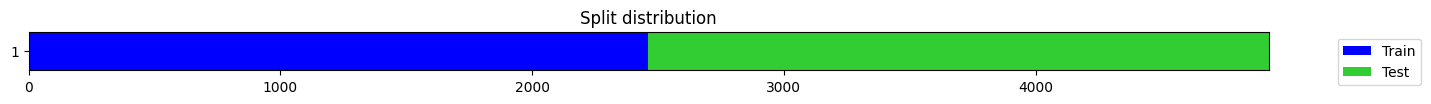

In [4]:
# 100% train data
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
check_data(X, y, splits)
dls100 = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
udls100 = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms) # used in pretraining

我们还需要一个带有 10% 训练数据和 100% 验证数据的标记数据加载器。
> We'll also need a labeled dataloaders with 10% of the training and 100% of validation data.

X      - shape: [4925 samples x 6 features x 36 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (4925,)  type: memmap  dtype:<U2  n_classes: 14 (351 samples per class) ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']  isnan: False
splits - n_splits: 2 shape: [245, 2466]  overlap: False


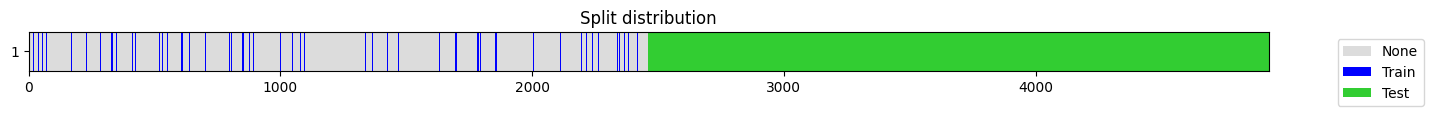

In [5]:
# 10% train data
train_split010 = get_splits(y[splits[0]], valid_size=.1, show_plot=False)[1]
splits010 = (train_split010, splits[1])
check_data(X, y, splits010)
dls010 = get_ts_dls(X, y, splits=splits010, tfms=tfms, batch_tfms=batch_tfms)

# 监督
> Supervised 👀

首先，我们将以监督方式训练模型来设置基线。我们将使用 10% 和 100% 的训练集进行训练。我们将进行 10 次测试。
> First we'll train a model in a supervised way to set a baseline. We'll train using 10% and 100% of the training set. We'll run 10 tests.

我们将使用相同的设置（50 个时期，10% 的标签，20 和 50 个时期，100% 的标签，lr=1e-2）训练所有模型，以查看预训练的影响。
>We'll train all models with the same settings (50 epochs with 10% of labels, 20 and 50 epochs with 100% of labels and lr=1e-2) to see the impact of pretraining.

9/10 accuracy: 0.568 +/- 0.009


epoch,train_loss,valid_loss,accuracy,time
0,2.557934,2.648675,0.077453,00:00
1,2.307331,2.604719,0.098540,00:00
2,2.070560,2.524580,0.361314,00:00
3,1.849173,2.366442,0.364964,00:00
4,1.683510,2.085469,0.405109,00:00
5,1.537650,1.872742,0.360503,00:00
6,1.441161,1.902838,0.444850,00:00
7,1.354052,4.768140,0.286294,00:00
8,1.280278,4.631732,0.244526,00:00
9,1.233995,6.859433,0.357259,00:00


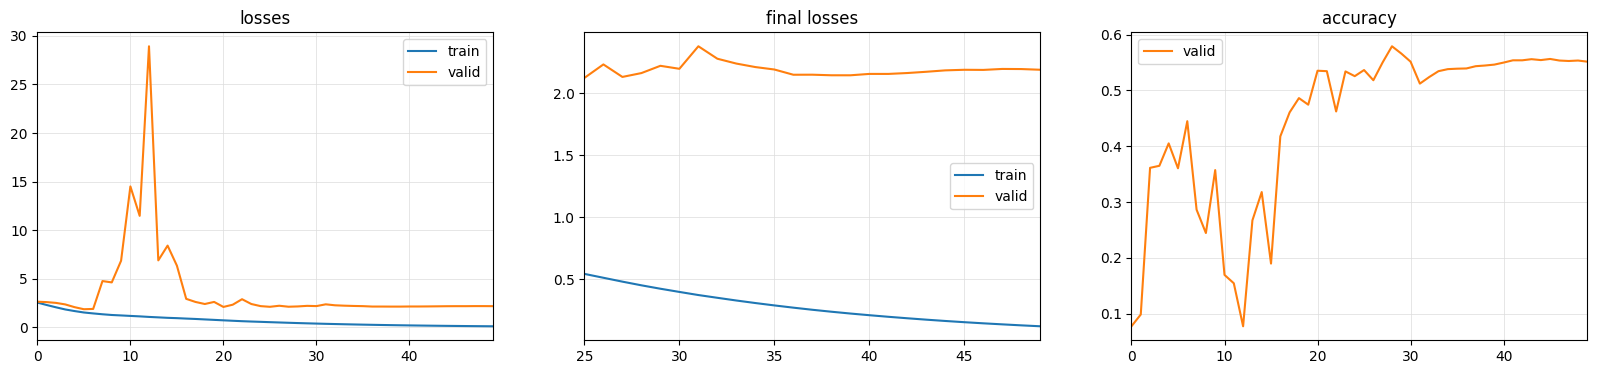


accuracy: 0.566 +/- 0.010 in 10 tests


In [6]:
# supervised 10%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.706 +/- 0.004


epoch,train_loss,valid_loss,accuracy,time
0,1.676919,1.452764,0.534063,00:01
1,1.335720,1.307144,0.579481,00:01
2,1.170903,1.515820,0.526358,00:01
3,1.095574,1.290196,0.588402,00:01
4,1.035425,1.286793,0.569343,00:01
5,0.996723,1.303516,0.581914,00:01
6,0.954733,1.208814,0.590835,00:01
7,0.908315,1.521987,0.615166,00:01
8,0.886815,1.086277,0.622871,00:01
9,0.854499,0.996721,0.674371,00:01


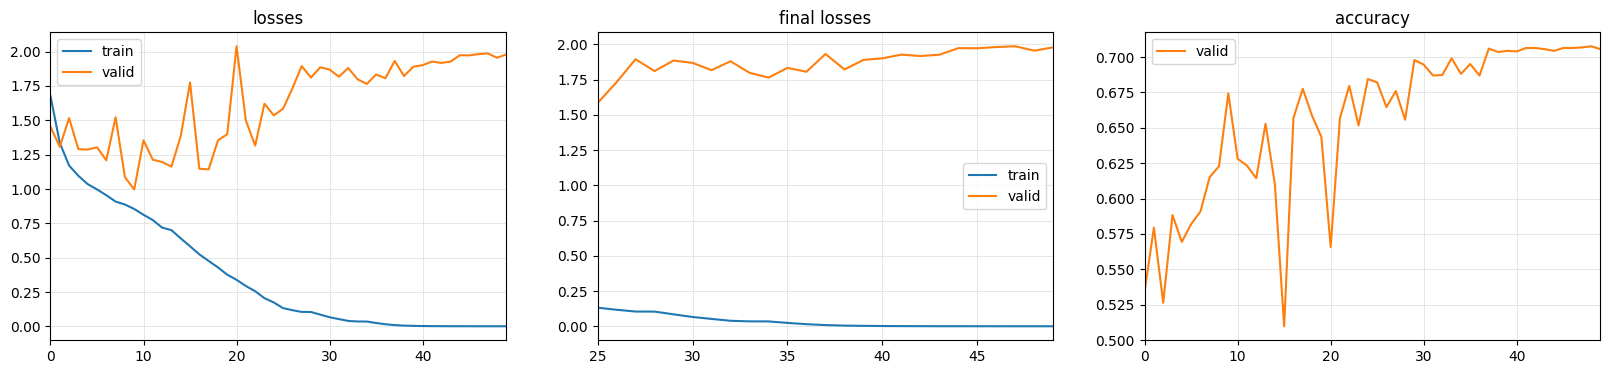


accuracy: 0.706 +/- 0.004 in 10 tests


In [7]:
# supervised 100%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

我还使用所有标签对模型进行了 20 次训练，因为它似乎在 50 次迭代中过度拟合。
> I've also trained the model with all labels for 20 as it seems to be overfitting with 50 epochs.

9/10 accuracy: 0.705 +/- 0.006


epoch,train_loss,valid_loss,accuracy,time
0,1.599909,1.467978,0.493512,00:00
1,1.291902,2.232035,0.426196,00:00
2,1.205260,1.653903,0.478913,00:00
3,1.115561,2.133754,0.421330,00:00
4,1.065954,1.175463,0.603001,00:00
5,1.000871,1.289316,0.523520,00:00
6,0.959918,1.626752,0.476480,00:01
7,0.891368,1.013119,0.668289,00:00
8,0.827849,0.914321,0.708435,00:01
9,0.754819,0.970679,0.690592,00:00


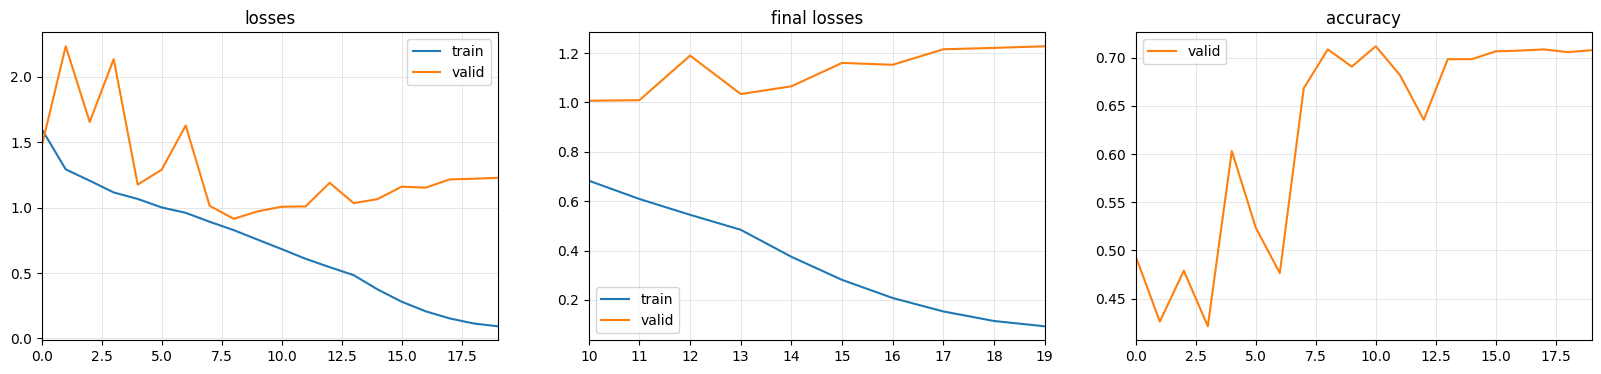


accuracy: 0.705 +/- 0.006 in 10 tests


In [8]:
# supervised 100%
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')


这是一个很好的结果。仅供参考，在最近对多元时间序列模型的回顾中（Ruiz, A. P.、Flynn, M.、Large, J.、Middlehurst, M. 和 Bagnall, A. (2020)。
> This is a great result. Just for reference, in a recent review of multivariate time series models (Ruiz, A. P., Flynn, M., Large, J., Middlehurst, M., & Bagnall, A. (2020). The 

伟大的多元时间序列分类烘焙：对最新算法进展的回顾和实验评估。数据挖掘和知识发现，1-49。），该数据集上性能最好的分类器是 MUSE，准确度为 63.62。
> great multivariate time series classification bake off: a review and experimental evaluation of recent algorithmic advances. Data Mining and Knowledge Discovery, 1-49.), the best performing classifier on this dataset is MUSE with an accuracy of **63.62**. 

让我们看看是否可以使用 MVP 改进我们的基线预训练 InceptionTime 。
> Let's see if we can improve our baseline pretraining InceptionTime using `MVP`.



# Pretrain model  🏋️‍♂️

现在我们将在整个训练集上训练一个没有任何标签的模型。为此，我们需要使用 MVP 回调。您可以访问 tsai 文档获取有关此回调的更多详细信息。

> Now we'll train a model without any labels on the entire training set. To do that we need to use the `MVP` callback. You can get more details on this callback visiting [`tsai` documentation](https://timeseriesai.github.io/tsai/callback.MVP).

epoch,train_loss,valid_loss,time


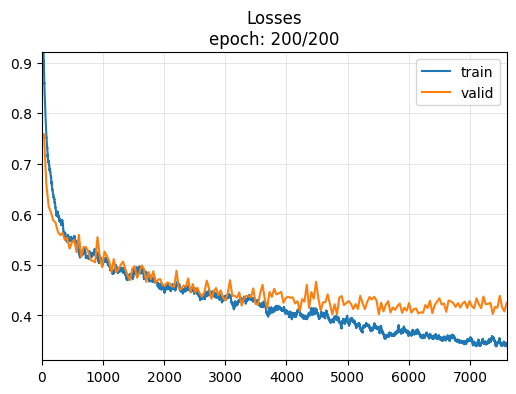


epochs: 200 best epoch: 126  val_loss: 0.401995 - pretrained weights_path='data/MVP/LSST_200.pth'



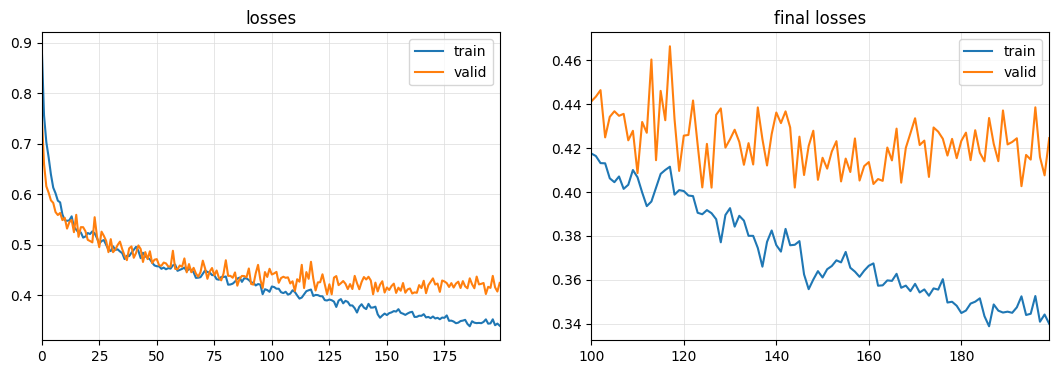

In [9]:
# Unlabeled 100%
learn = ts_learner(udls100, InceptionTimePlus, cbs=[ShowGraph(), MVP(target_dir='./data/MVP', fname=f'{dsid}_200')])
learn.fit_one_cycle(200, 1e-2)

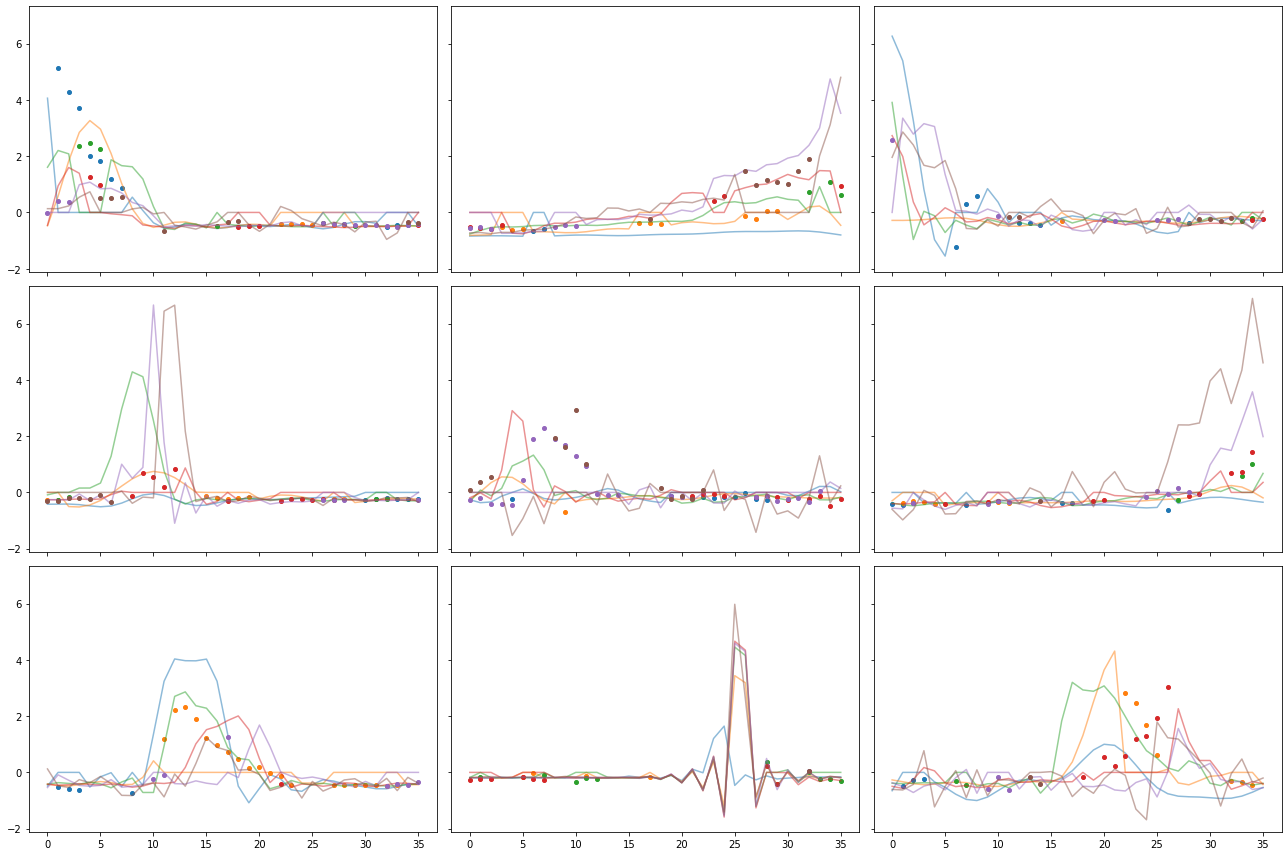

In [ ]:
learn.MVP.show_preds(sharey=True)

# Fine-tune 🎻

至少有 2 个选项可以使用预训练模型权重：

> There are at least 2 options to use the pretrained model weights: 

1.   Fine-tune 微调
2.   Train 训练

我们将从微调预训练模型开始。

> We'll start by fine-tuning the pretrained model.

在这种情况下，我们将base_lr加倍，因为训练lr将是base_lr / 2。微调的唯一净变化只是对新头进行10个epoch的训练。其余的训练将是相同的。
> In this case, we double the base_lr as the training lr will be the base_lr / 2. The only net change of the fine tuning then is just a training of the new head for 10 epochs. The rest of the training will be the same.

不过，在训练之前，我们将检查当模型被冻结时，是否只训练了最后一层：
> Before training though, we'll check that when the model is frozen only the last layer is trained: 

In [10]:
learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
for p in learn.model.parameters():
    p.requires_grad=False
print(f'{"trainable params once manually frozen":40}: {count_parameters(learn.model):8}')
learn.freeze()
print(f'{"trainable params after learn.freeze()":40}: {count_parameters(learn.model):8}')
learn.unfreeze()
print(f'{"trainable params learn.unfreeze()":40}: {count_parameters(learn.model):8}')

weights from data/MVP/LSST_200.pth successfully transferred!

trainable params once manually frozen   :        0
trainable params after learn.freeze()   :     3854
trainable params learn.unfreeze()       :   457614


看起来效果很好。

It seems to be working well.

9/10 accuracy: 0.608 +/- 0.003
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.692357,2.650050,0.130170,00:00
1,2.662741,2.566997,0.179643,00:00
2,2.608081,2.425727,0.197486,00:00
3,2.538575,2.242551,0.227494,00:00
4,2.457504,2.065394,0.293593,00:00
5,2.371033,1.928738,0.382401,00:00
6,2.284885,1.825222,0.399027,00:00
7,2.202481,1.717502,0.427007,00:00
8,2.123799,1.614793,0.487024,00:00
9,2.041018,1.540966,0.526358,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.497399,1.523981,0.526358,00:00
1,1.481755,1.514992,0.526358,00:00
2,1.463121,1.506521,0.522709,00:00
3,1.445810,1.496821,0.525547,00:00
4,1.432648,1.486031,0.527981,00:00
5,1.426437,1.475693,0.530414,00:00
6,1.426183,1.457100,0.534063,00:00
7,1.418779,1.439488,0.539335,00:00
8,1.396927,1.422322,0.548662,00:00
9,1.386375,1.404586,0.552311,00:00


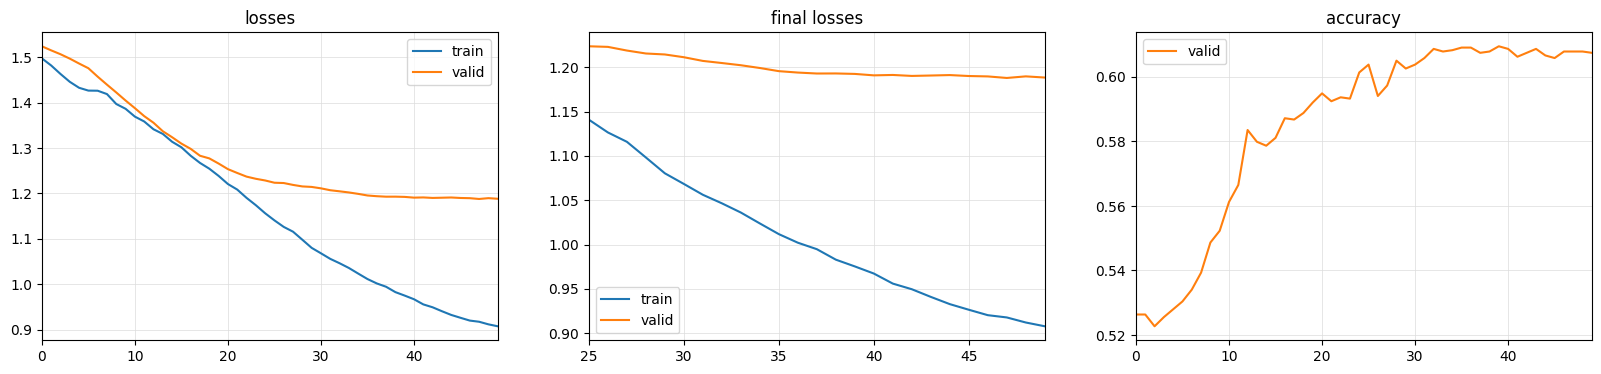


accuracy: 0.608 +/- 0.003 in 10 tests


In [11]:
# self-supervised: fine-tuning with 10% labels
n_epochs = 50
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.706 +/- 0.002
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.439601,2.198535,0.311436,00:00
1,2.128868,1.833657,0.392539,00:00
2,1.851416,1.535818,0.500405,00:00
3,1.609936,1.332858,0.587591,00:00
4,1.409151,1.201077,0.602595,00:01
5,1.266459,1.128582,0.619221,00:01
6,1.153368,1.058975,0.653690,00:00
7,1.079874,1.068280,0.646796,00:00
8,1.023551,1.025139,0.662206,00:00
9,0.977815,0.991230,0.671127,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.885703,0.967843,0.678021,00:01
1,0.872937,0.962065,0.685726,00:00
2,0.870499,0.961285,0.686131,00:00
3,0.865028,0.960053,0.684104,00:00
4,0.858169,0.957575,0.685726,00:00
5,0.855267,0.959688,0.688159,00:00
6,0.853886,0.968760,0.684104,00:00
7,0.846911,0.955871,0.686131,00:00
8,0.842225,0.946734,0.691403,00:00
9,0.840077,0.952006,0.688564,00:00


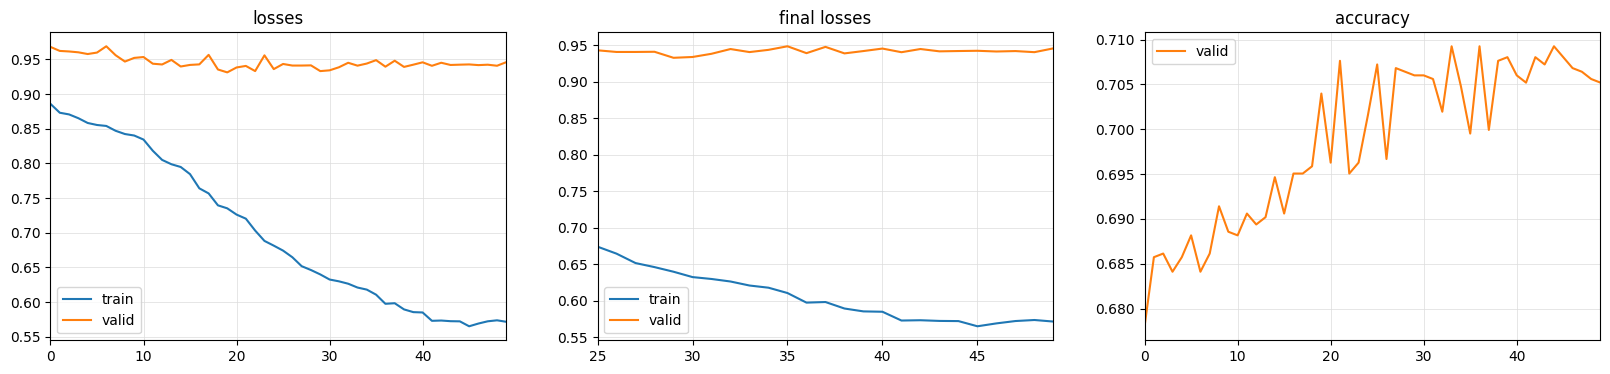


accuracy: 0.705 +/- 0.002 in 10 tests


In [12]:
# self-supervised: fine-tuning with 100% labels
n_epochs = 50
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.700 +/- 0.002
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.356201,2.129471,0.334550,00:00
1,2.080543,1.807348,0.403082,00:00
2,1.823131,1.526358,0.520276,00:00
3,1.596108,1.325483,0.558800,00:00
4,1.405157,1.179595,0.635442,00:00
5,1.258393,1.105157,0.649230,00:00
6,1.147464,1.037306,0.654907,00:00
7,1.063072,1.019152,0.654907,00:00
8,1.024321,1.015287,0.662612,00:00
9,0.968750,1.009782,0.666261,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.880691,0.969902,0.682482,00:00
1,0.872570,0.964862,0.684509,00:00
2,0.864282,0.979683,0.679643,00:00
3,0.864878,0.967380,0.681671,00:00
4,0.861434,0.956664,0.685320,00:00
5,0.855387,0.969554,0.684915,00:01
6,0.835494,0.967806,0.686942,00:00
7,0.825134,0.955770,0.691809,00:01
8,0.818796,0.956495,0.685726,00:00
9,0.810681,0.963234,0.685726,00:00


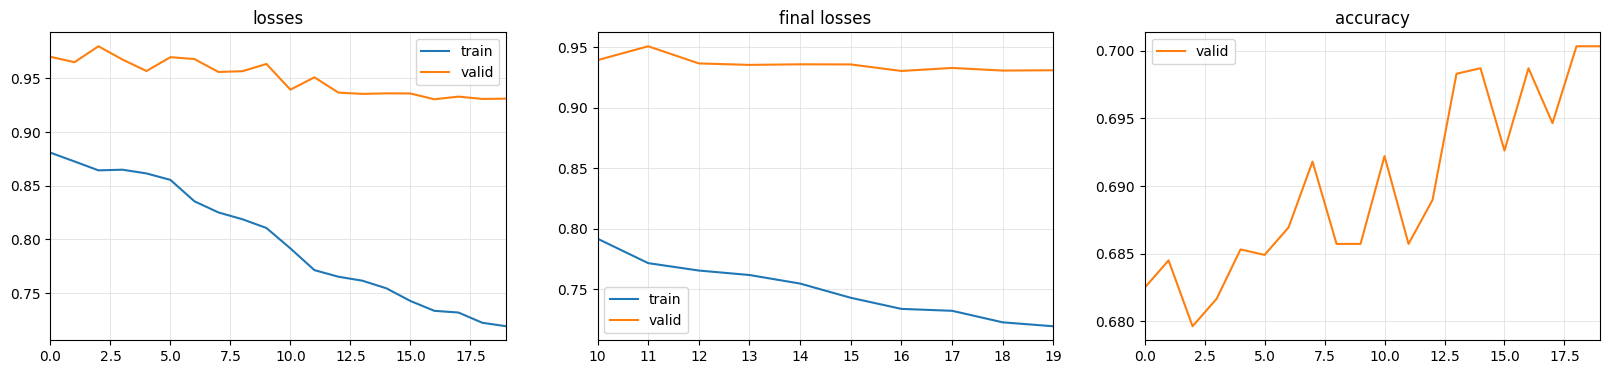


accuracy: 0.700 +/- 0.002 in 10 tests


In [13]:
# self-supervised: fine-tuning with 100% labels
n_epochs = 20
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

# Train 🏃🏽‍♀️🏃🏽‍♀

9/10 accuracy: 0.609 +/- 0.008
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.641008,2.622890,0.024736,00:00
1,2.621611,2.571871,0.030414,00:00
2,2.588986,2.486172,0.139497,00:00
3,2.545437,2.351767,0.386861,00:00
4,2.483099,2.159425,0.435118,00:00
5,2.399148,1.925861,0.434307,00:00
6,2.304345,1.741249,0.431873,00:00
7,2.197829,1.635894,0.440389,00:00
8,2.097762,1.515087,0.492701,00:00
9,1.987319,1.389046,0.557178,00:00


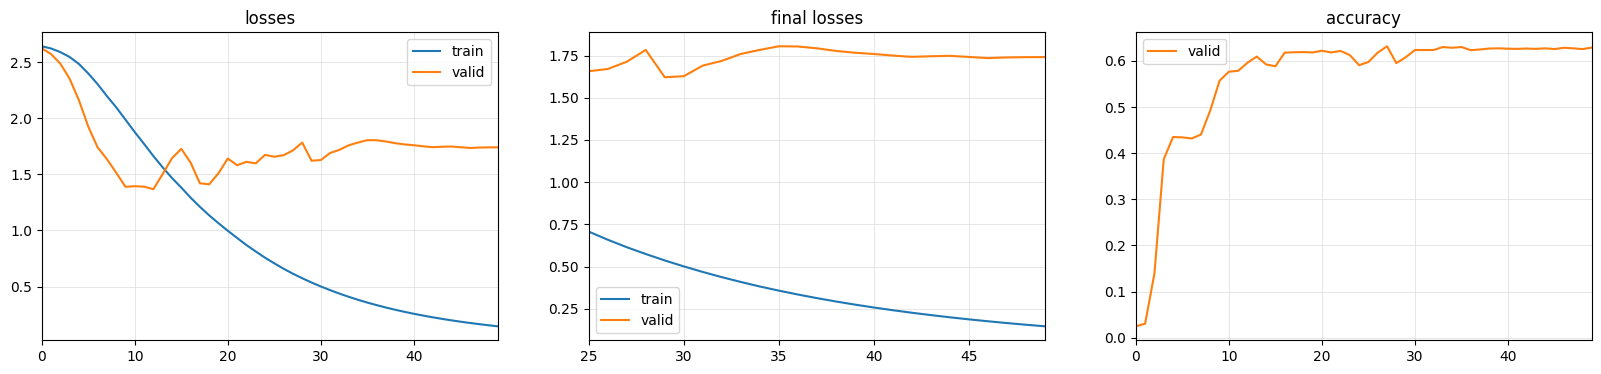


accuracy: 0.611 +/- 0.010 in 10 tests


In [14]:
# self-supervised: train with 10% labels
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.719 +/- 0.006
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.461575,2.261452,0.416058,00:00
1,2.132355,1.686783,0.464720,00:00
2,1.755620,1.315356,0.549473,00:00
3,1.431002,1.069727,0.649635,00:00
4,1.193373,1.010528,0.665450,00:00
5,1.027204,0.940310,0.689376,00:00
6,0.902564,0.973312,0.690998,00:00
7,0.809224,0.999675,0.682076,00:00
8,0.725303,0.986135,0.690187,00:00
9,0.646508,0.977384,0.702352,00:00


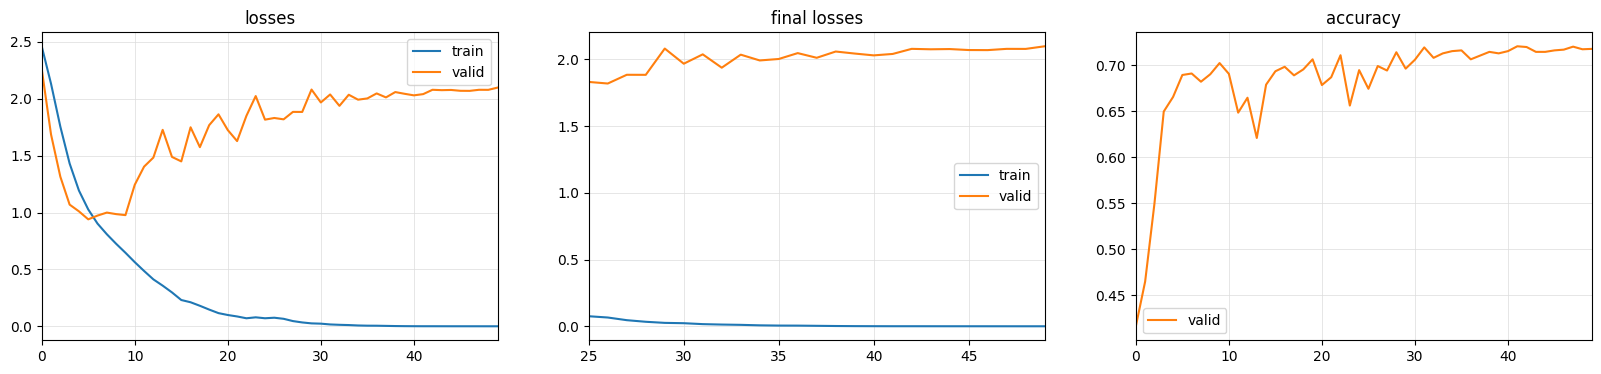


accuracy: 0.719 +/- 0.006 in 10 tests


In [15]:
# self-supervised: train with 100% labels
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.724 +/- 0.004
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.467971,2.101873,0.435929,00:00
1,1.910440,1.283901,0.579075,00:00
2,1.425917,1.063711,0.660989,00:00
3,1.148331,0.980706,0.681265,00:00
4,0.980555,1.069422,0.650852,00:00
5,0.851596,0.978978,0.691403,00:00
6,0.738944,1.048859,0.680049,00:00
7,0.638179,1.022798,0.680049,00:00
8,0.528205,1.046520,0.698297,00:00
9,0.414438,1.181404,0.687753,00:00


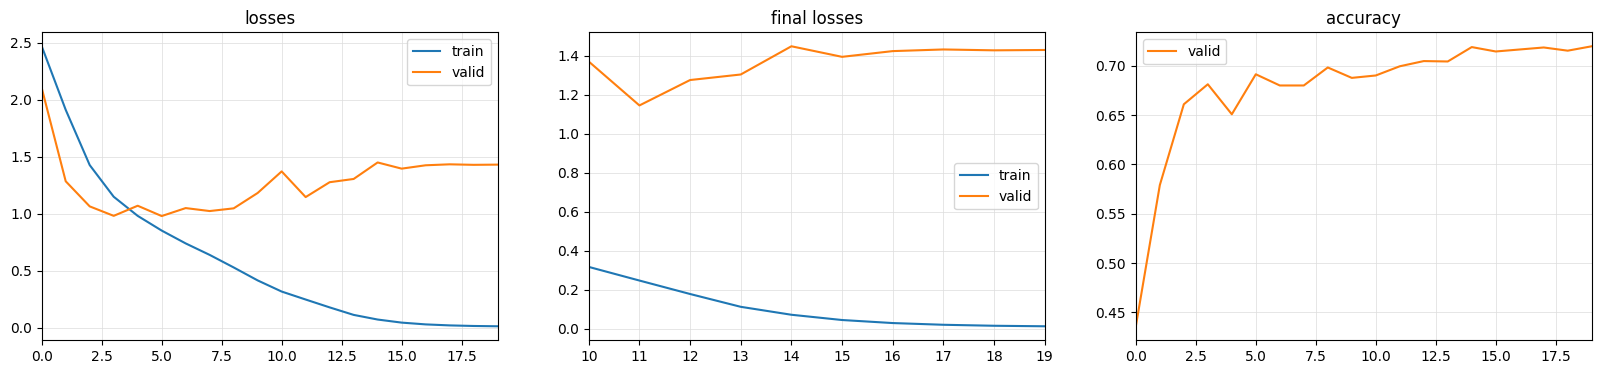


accuracy: 0.723 +/- 0.004 in 10 tests


In [16]:
# self-supervised 100% + training
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

# 添加数据增强 🔎🔎

> Adding data augmentation 🔎🔎

我想测试的最后一件事是使用预训练模型时数据增强的影响。

> One last thing I'd like to test is the impact of data augmentation when using a pretrained model. 

我将比较从头开始训练的模型和添加 CutMix（ tsai 中的 CutMix1D）的预训练模型的性能。我们将看看性能差异是否仍然存在。

> I will compare the performance of a model trained from scratch and a pretrained model adding CutMix (CutMix1D in `tsai`). We'll see if the difference in performance still holds.

9/10 accuracy: 0.733 +/- 0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.862071,1.528906,0.485807,00:01
1,1.706570,1.220499,0.613139,00:01
2,1.617663,1.369695,0.517843,00:01
3,1.588272,1.364724,0.568126,00:01
4,1.571381,1.375109,0.586375,00:01
5,1.533075,1.112029,0.670722,00:01
6,1.477976,1.099101,0.654096,00:01
7,1.459541,1.066880,0.689781,00:01
8,1.440436,1.005300,0.699108,00:01
9,1.386207,1.013992,0.673155,00:01


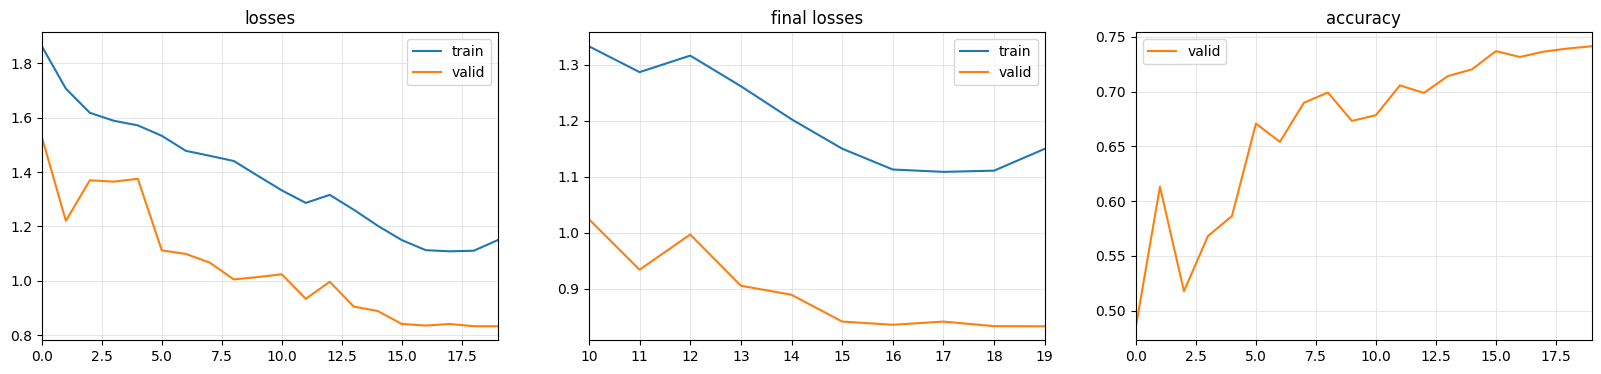


accuracy: 0.734 +/- 0.005 in 10 tests


In [17]:
# self-supervised 100% + training
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy, cbs=CutMix1d())
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.746 +/- 0.005
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.510118,2.203270,0.297242,00:01
1,2.100174,1.395225,0.538524,00:01
2,1.803496,1.187580,0.635848,00:01
3,1.645750,1.113493,0.640714,00:01
4,1.527438,1.055209,0.664639,00:01
5,1.480316,1.008729,0.687753,00:01
6,1.448499,0.998382,0.705191,00:00
7,1.400767,0.954662,0.705596,00:01
8,1.343822,0.968283,0.707624,00:01
9,1.311662,0.925717,0.717356,00:01


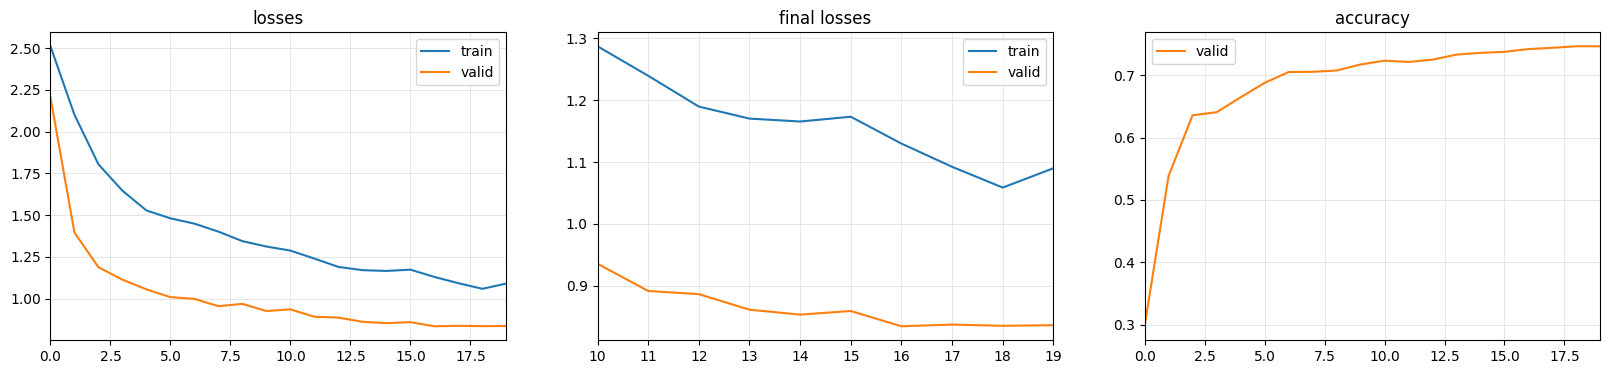


accuracy: 0.746 +/- 0.004 in 10 tests


In [18]:
# self-supervised 100% + training with cutmix
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy, cbs=CutMix1d())
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

正如您所看到的，CutMix 在这两种情况下都提高了性能，但预训练模型的性能仍然更好。

> As you can see CutMix improves performance in both cases, but the pretrained model still performs better.

# Conclusions ✅

MVP 是添加到 tsai 库中的第一个自监督方法。而且看起来效果很好。它展示了一些非常有趣的东西：无论是否有额外的未标记数据，自我监督学习都可以提高性能。

> `MVP` is the first self-supervised method added to the `tsai` library. And it seems to work pretty well. It shows something really interesting: self-supervised learning may improve performance, with or without additional unlabeled data.

在此笔记本中，我们通过两个步骤演示了使用自我监督方法是多么容易：
> In this notebook we've demonstrated how easy it is to use a self-supervised method in 2 steps: 

1. 使用 MVP 回调预训练架构。
1. > pretrain an architecture using the `MVP` callback.
2. 使用预训练的模型权重微调或训练相同的架构。
3. > fine-tune or train the same architecture using the pretrained model weights.

在所有情况下，使用预训练模型权重作为起点时，性能都会更好。
> In all cases, performance has been better when using the pretrained model weights as a starting point. 

在这种情况下，训练被证明优于微调。然而，情况并非总是如此。很难预先知道微调或训练是否会提供更好的结果。我建议尝试这两种方法。
> In this case, training has proven to be superior to fine-tuning. However, this will not always be the case. It's difficult to know a priori whether fine/tuning or training will provide better results. I'd recommend trying both approaches. 

在使用数据增强（dataaugmentation）的情况下，我们还看到预训练的模型比从头开始训练的模型表现更好。
> In the case of using data augmentation (data augmentation), we've also seen that the pretrained model performs better than the one trained from scratch.

MVP 已经表明，它可以通过较少数量的标签 （10%） 和所有标签 （100%） 来提高性能。
> `MVP` has shown it can improve performance with a low number of labels (10%) as well as with all labels (100%). 

我鼓励您将 MVP 与您自己的数据集一起使用并分享您的经验。
> I'd encourage you to use `MVP` with your own datasets and share your experience.